In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle
from sklearn.manifold import TSNE
import umap
import mpld3

In [5]:
data = pickle.load( open( "sparse_light_curves_python2.pickle", "rb" ) )

kdata = np.load('KeplerSampleFullQ.npy',encoding='bytes')
full_data = np.load("sparse_light_curve_dmdt_final/full_sparse_light_curve_points.npy")

full_data.shape
reshaped_data = full_data.reshape(2500, 399)
    
def plot_sparse(data_arr, lc_index):
    if data_arr >= 3:
        x = data[data_arr][lc_index].T[0]
        y = data[data_arr][lc_index].T[1]
        plt.plot(x,y)
    else:
        x = data[data_arr][lc_index][0]
        y = data[data_arr][lc_index][1]
        plt.plot(x,y)

In [18]:
weird_points = [704, 1109, 1102, 2344, 1944, 363, 34, 1174, 90, 1258, 1411, 1145]
def plot_lc(emedded_mat, title, outliers=None, baseline_outliers=weird_points, save_plot=False):
    x = emedded_mat[:, 0]
    y = emedded_mat[:, 1]
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    N = len(x)
    hehe = []
    s = []
    shapes = []
    for i in range(N):
        if i == 1156:
            hehe.append('r')
            s.append(80)
        if i in baseline_outliers:
            hehe.append('g')
            s.append(30)
            shapes.append("x")
        else:
            hehe.append("#660066")
            s.append(1)
            shapes.append(".")
        
    hehe = np.array(hehe)
    s = np.array(s)
    
    scatter = ax.scatter(x,
                         y,
                         c=hehe,
                         s=s,
                         alpha=0.3,
                         zorder=10)
    ax.grid(color='white', linestyle='solid', zorder=0)

    ax.set_title(title, size=15)
    
    if save_plot:
        print "here"
        plt.savefig("final_images_sparse/" + str(title) +".ps", dpi=1500)

    labels = ['point {0}'.format(i + 1) for i in range(N)]
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

In [7]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=30)
pca_embeddings = pca_model.fit_transform(reshaped_data)

p = 200
ee = 5
lr = 50
tsne_model = TSNE(n_components=2, perplexity=p, early_exaggeration=ee, learning_rate=lr)
tsne_embeddings_pca = tsne_model.fit_transform(pca_embeddings)
print tsne_model.kl_divergence_

0.329409211874


here


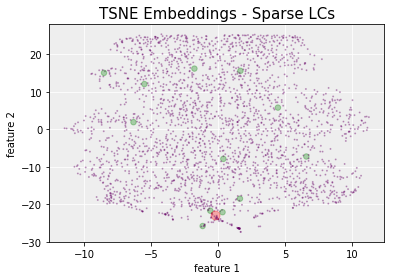

In [19]:
plot_lc(tsne_embeddings_pca, "TSNE Embeddings - Sparse LCs", save_plot=True)

In [117]:
neighbors = 200
min_dist = 0.4
learning_rate = 0.25

model_umap = umap.UMAP(n_neighbors=neighbors, min_dist=min_dist, learning_rate=learning_rate)
embeddings_umap_pca = model_umap.fit_transform(pca_embeddings)

here


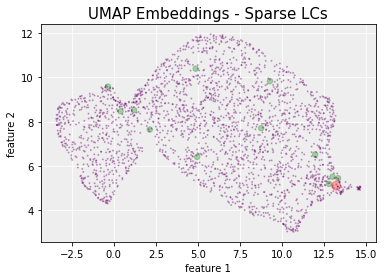

In [130]:
plot_lc(embeddings_umap_pca, "UMAP Embeddings - Sparse LCs", save_plot=True)

In [36]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import cKDTree


def find_outliers(distances, metric='min', name="test", cutoff=3, neg_cutoff=None, r=None):
    if metric == 'ball':
        if r is None:
            r = 1
        lookup_tree = cKDTree(distances)
        ball_count = []
        print r
        for point in distances:
            ball_count.append(len(lookup_tree.query_ball_point(point, r)))
        distribution = np.array(ball_count)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        plt.title("NNeighbors in Ball of radius" + str(r) + "distance distribution for embedding: " + name)
        plt.hist(normalized, bins=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        normalized_scores = []
        if neg_cutoff:
            for i, _ in enumerate(normalized):
                if normalized[i] < neg_cutoff:
                    normalized_scores.append(normalized[i])
                    outliers.append(i)
        
        for i in outliers:
            plt.title("outlier " + str(i) + " for embeddings: " + name)
            plot_sparse(4, i)
            plt.show()
            print normalized[i]
        return outliers, normalized_scores
    elif metric == 'average':
        distribution = np.mean(distances, axis=1)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        plt.title("mean distance distribution for embedding: " + name)
        plt.hist(normalized, bins=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        for i in outliers:
            plt.title("outlier " + str(i) + " for embeddings: " + name)
            real_plot(i)
            print normalized[i]
        return outliers
    elif metric == 'min':
        distribution = []
        for i, _ in enumerate(distances):
            min_elem = np.min(np.concatenate((distances[i,:i], distances[i, i+1:]), axis=None))
            distribution.append(min_elem)
        distribution = np.array(distribution)
        average = np.mean(distribution)
        std = np.std(distribution)
        normalized = np.apply_along_axis(lambda x: (x-average)/std, 0, distribution)
        plt.title("min distance distribution for embedding: " + name)
        plt.hist(normalized, bins=100)
        plt.show()
        outliers = [i for i, _ in enumerate(normalized) if normalized[i] > cutoff]
        for i in outliers:
            plt.title("outlier " + str(i) + " for embeddings: " + name)
            plot_sparse(4, i)
            plt.show()
            print normalized[i]
        return outliers

5


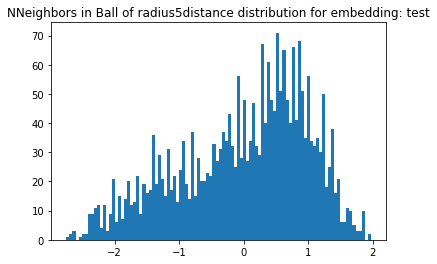

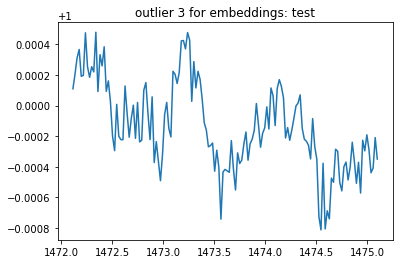

-2.2741080152100204


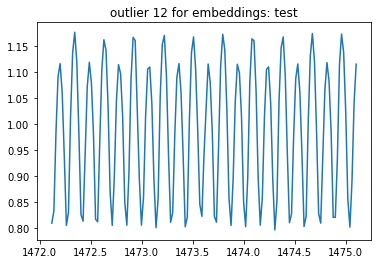

-2.3727647172657487


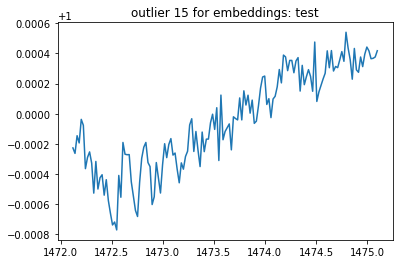

-2.0570632706874177


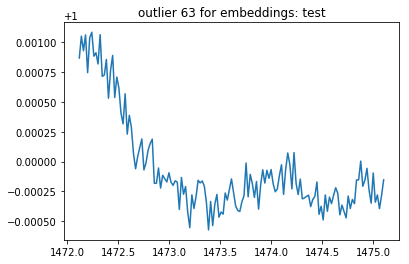

-2.234645334387729


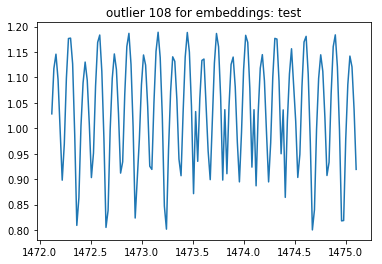

-2.3727647172657487


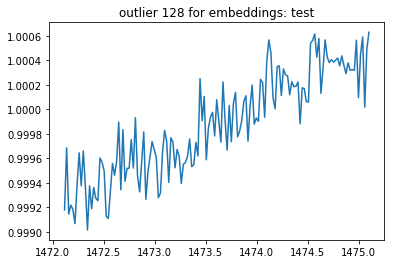

-2.1754513131542916


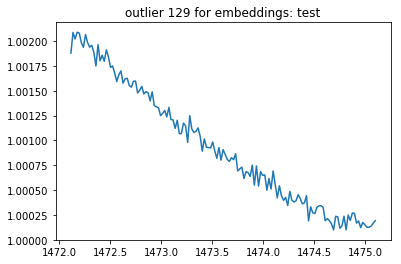

-2.293839355621166


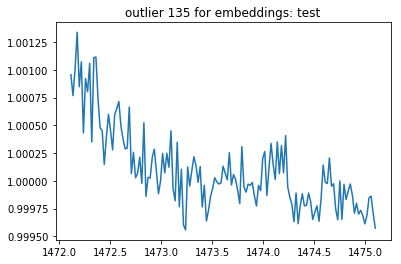

-2.155719972743146


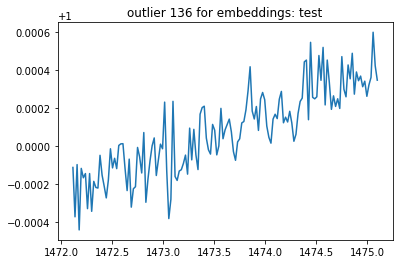

-2.293839355621166


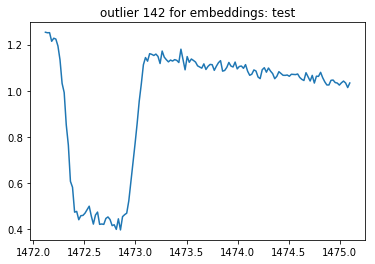

-2.6292721426106427


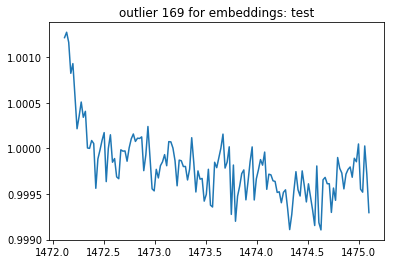

-2.0767946110985633


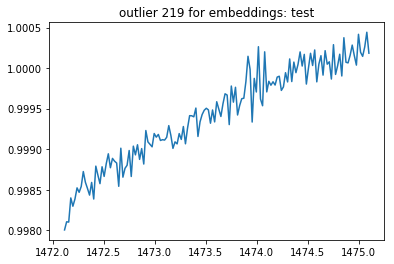

-2.037331930276272


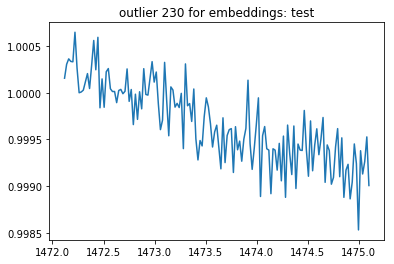

-2.293839355621166


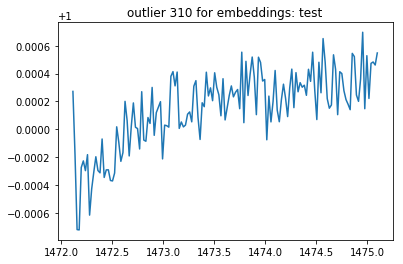

-2.155719972743146


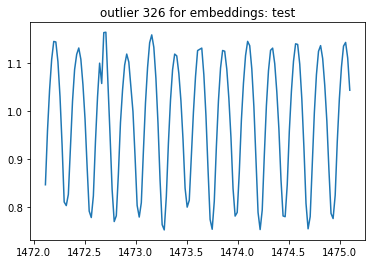

-2.3727647172657487


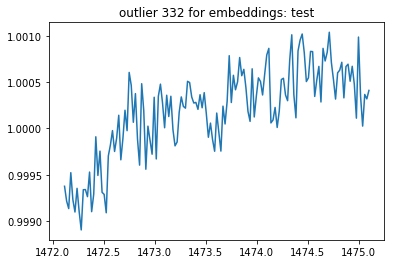

-2.1162572919208547


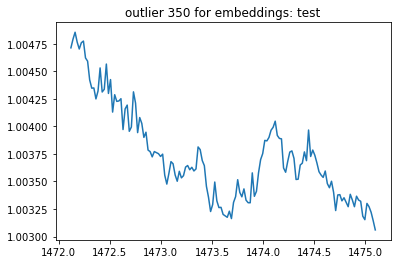

-2.1359886323320003


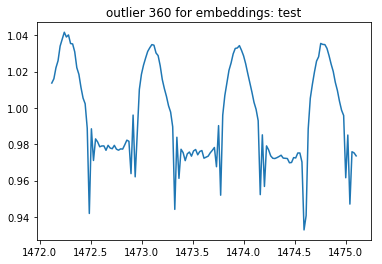

-2.3333020364434574


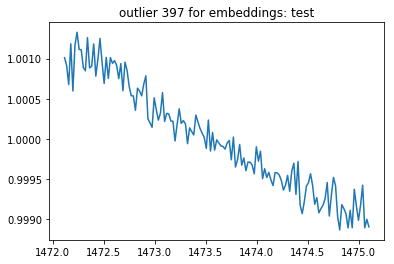

-2.234645334387729


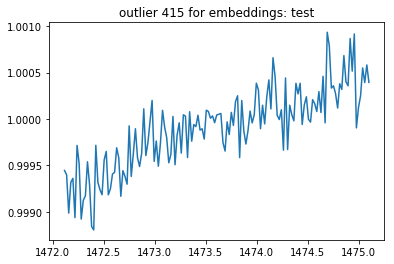

-2.0570632706874177


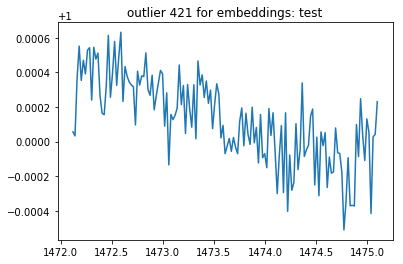

-2.037331930276272


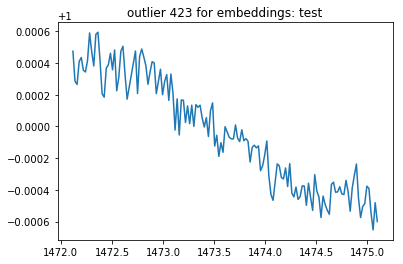

-2.668734823432934


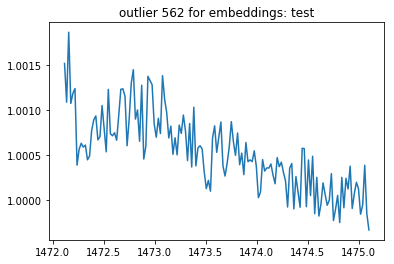

-2.1359886323320003


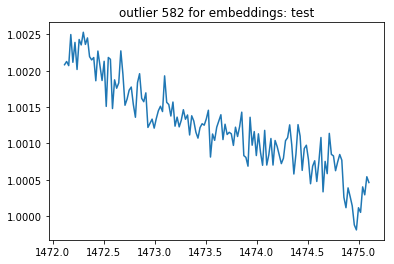

-2.037331930276272


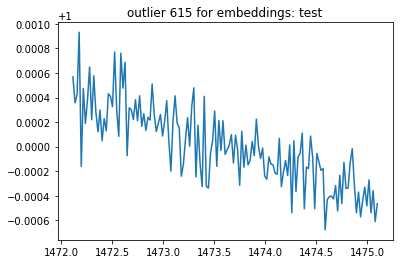

-2.234645334387729


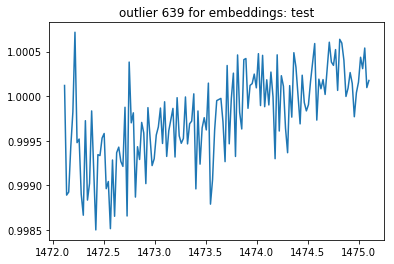

-2.155719972743146


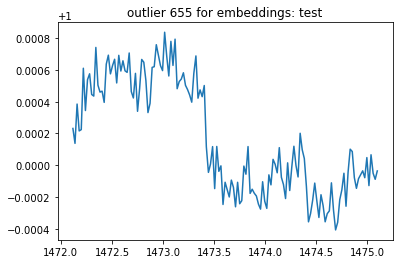

-2.471421419321477


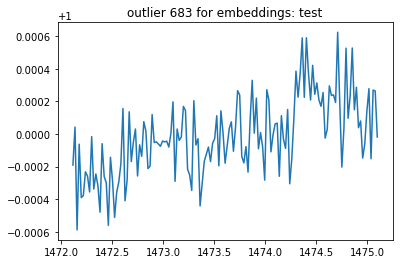

-2.0570632706874177


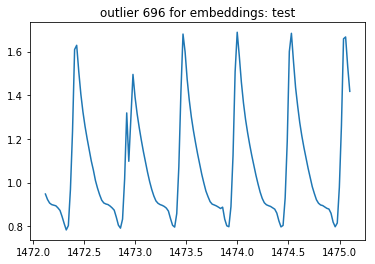

-2.3333020364434574


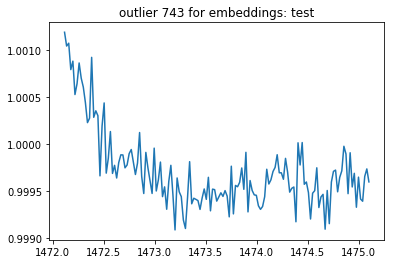

-2.0767946110985633


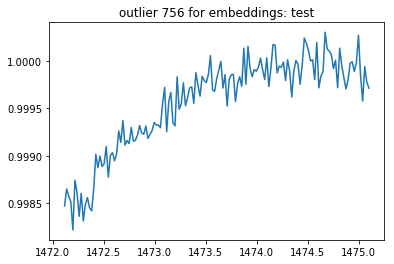

-2.41222739808804


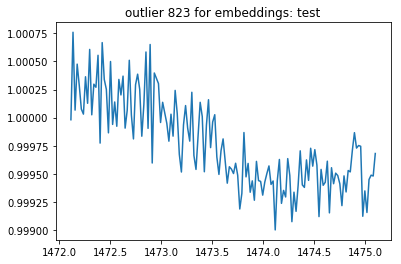

-2.155719972743146


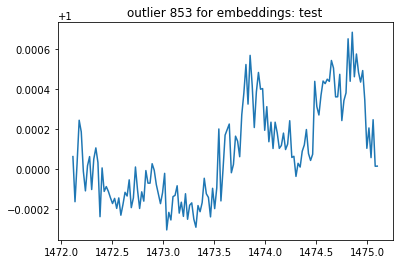

-2.1162572919208547


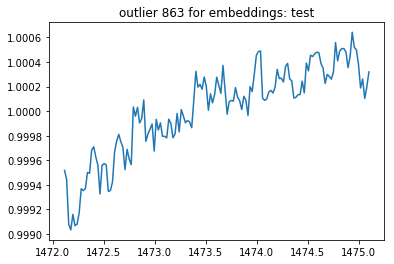

-2.0176005898651264


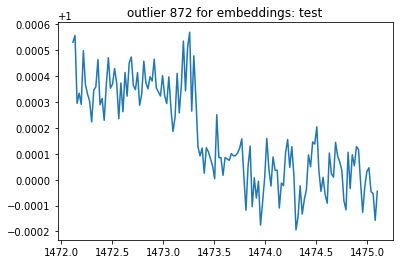

-2.0570632706874177


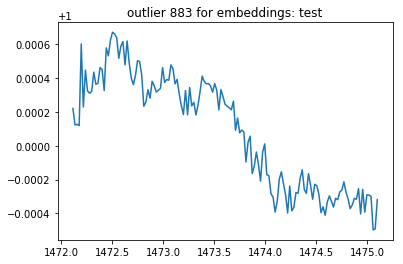

-2.609540802199497


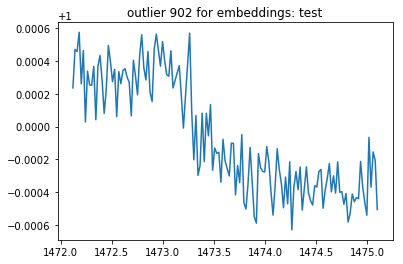

-2.5108841001437683


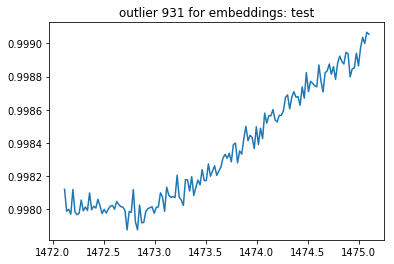

-2.1951826535654377


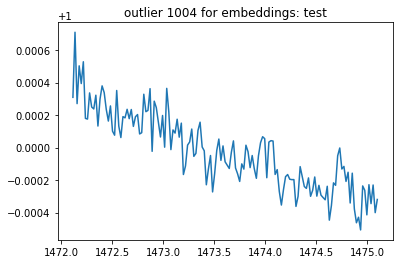

-2.234645334387729


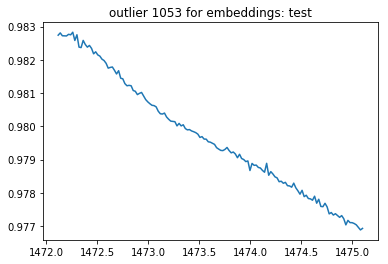

-2.0570632706874177


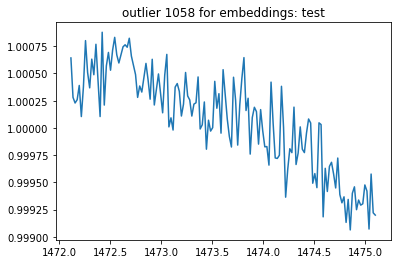

-2.096525951509709


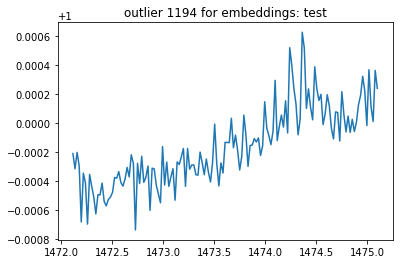

-2.353033376854603


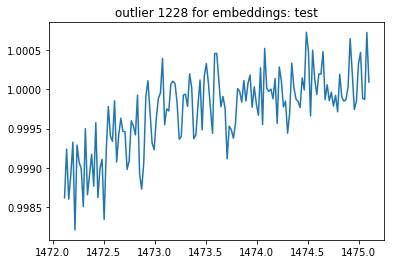

-2.1359886323320003


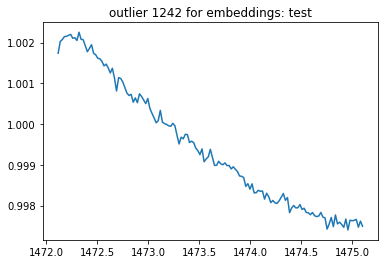

-2.037331930276272


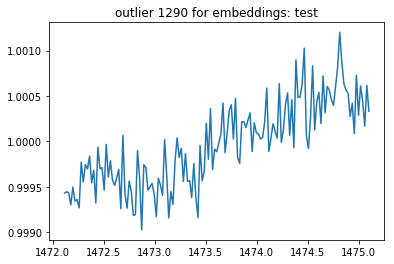

-2.1359886323320003


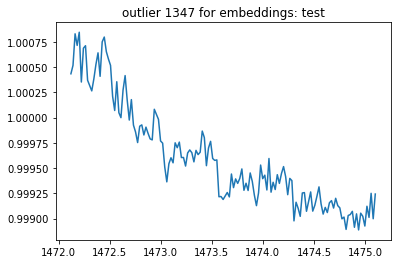

-2.1951826535654377


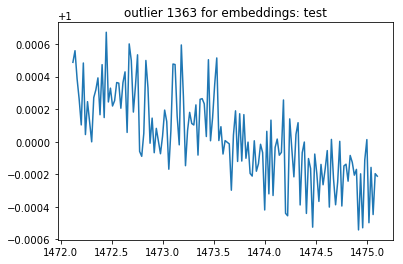

-2.037331930276272


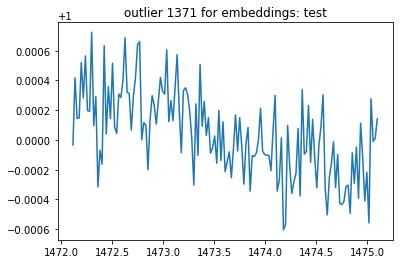

-2.353033376854603


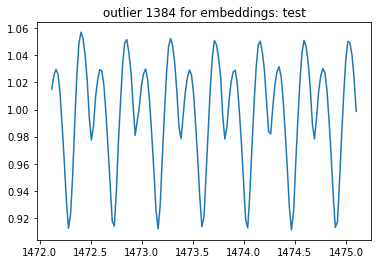

-2.3333020364434574


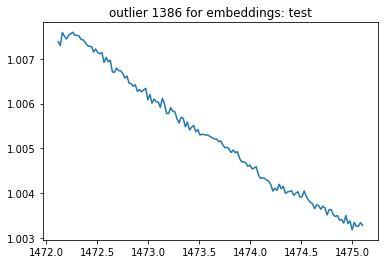

-2.037331930276272


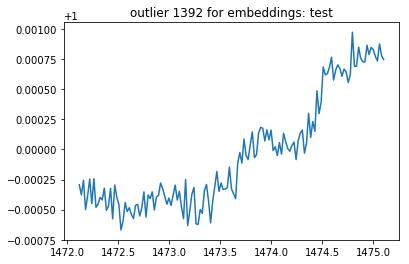

-2.3727647172657487


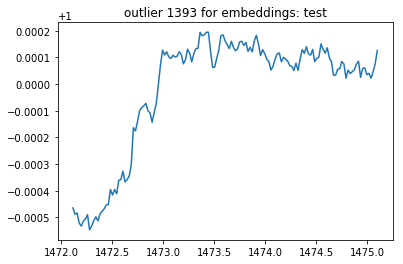

-2.530615440554914


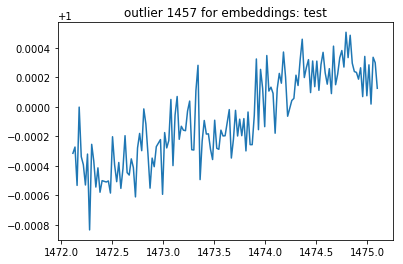

-2.037331930276272


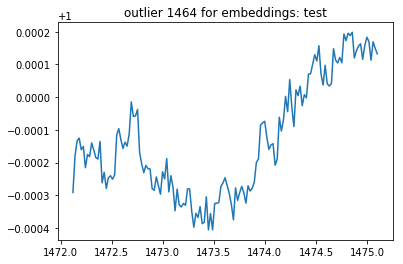

-2.2149139939765834


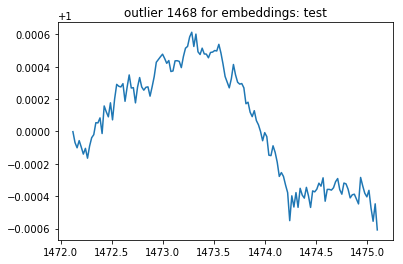

-2.4319587384991856


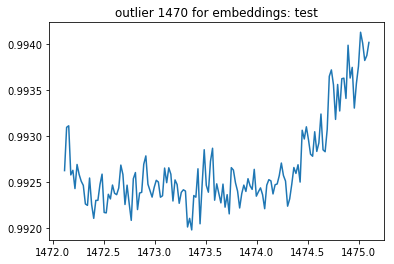

-2.2543766747988747


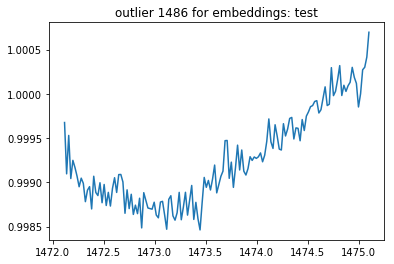

-2.155719972743146


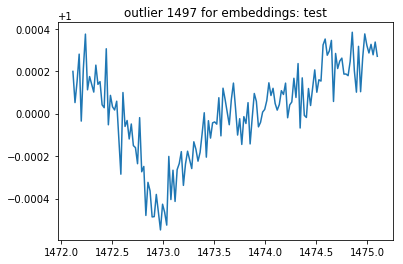

-2.234645334387729


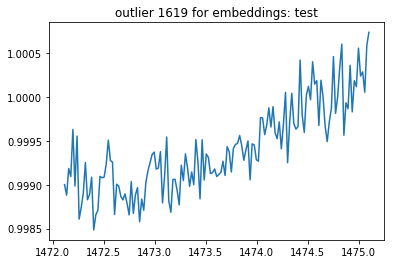

-2.3727647172657487


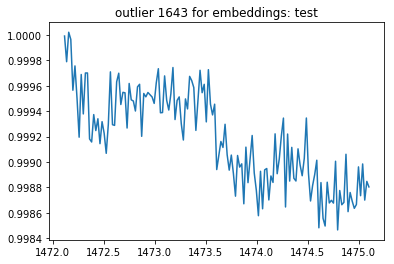

-2.234645334387729


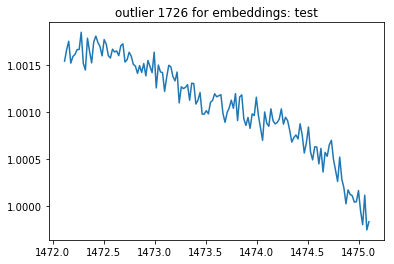

-2.293839355621166


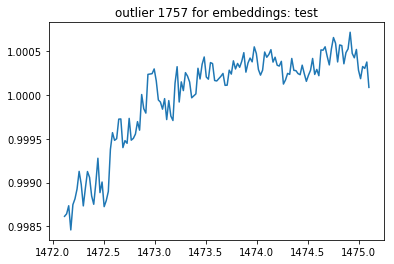

-2.3924960576768943


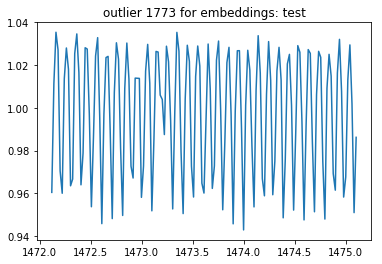

-2.234645334387729


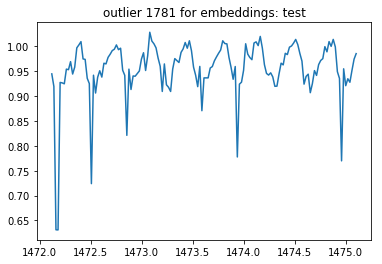

-2.3333020364434574


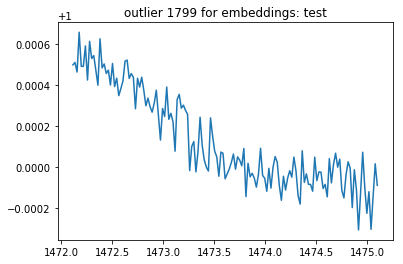

-2.293839355621166


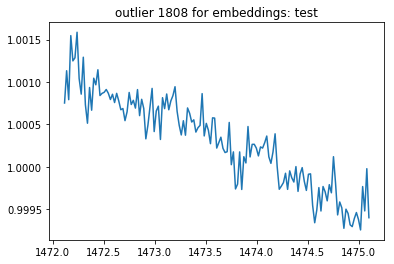

-2.1359886323320003


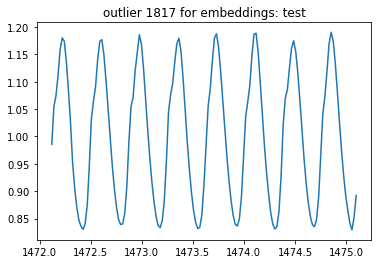

-2.3135706960323117


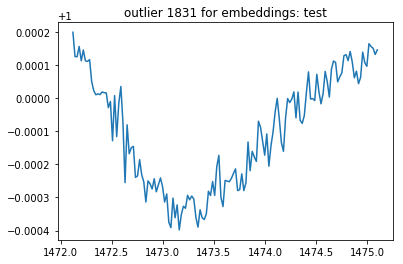

-2.3135706960323117


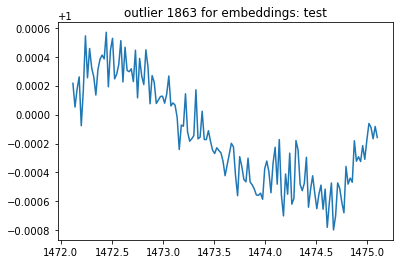

-2.4319587384991856


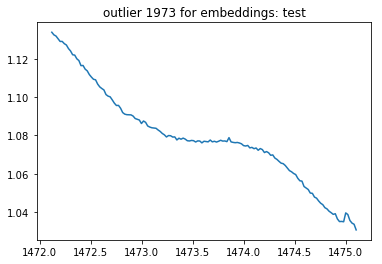

-2.6292721426106427


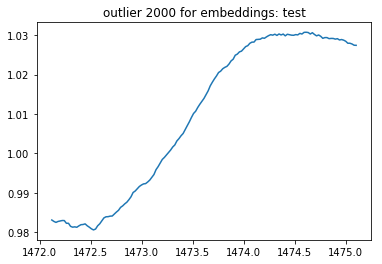

-2.2741080152100204


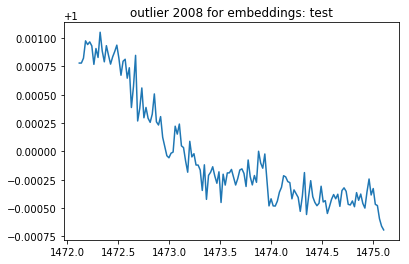

-2.234645334387729


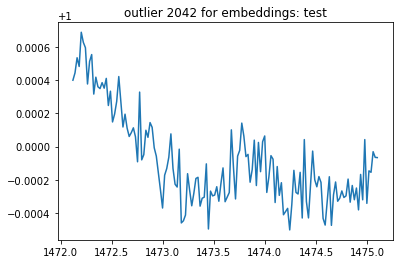

-2.234645334387729


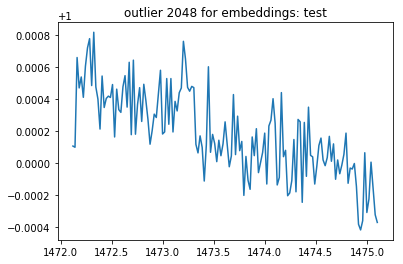

-2.037331930276272


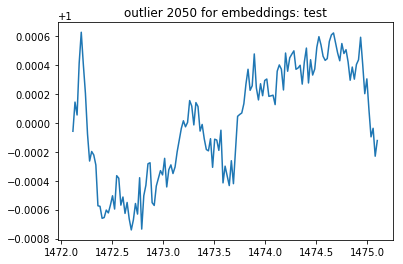

-2.037331930276272


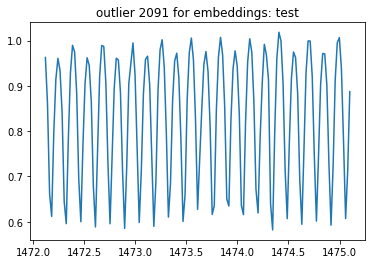

-2.3727647172657487


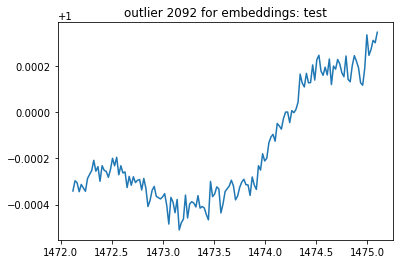

-2.668734823432934


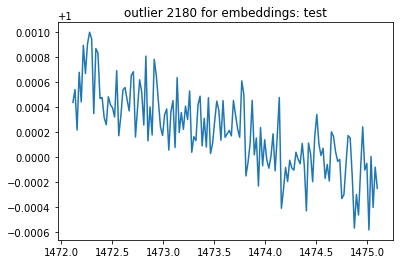

-2.1951826535654377


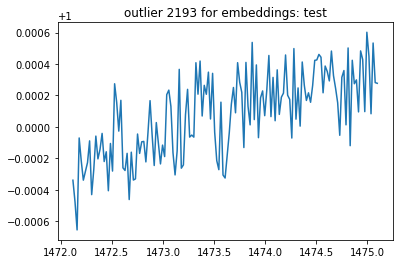

-2.0570632706874177


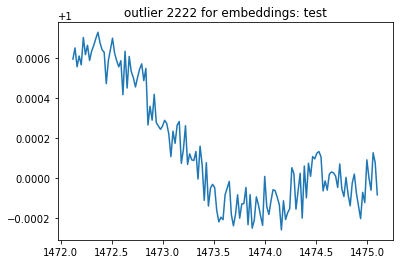

-2.3135706960323117


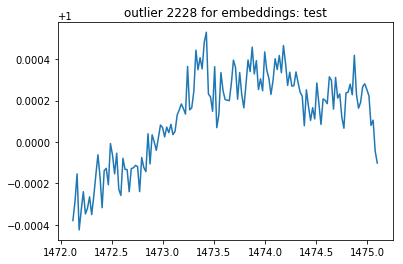

-2.7476601850775166


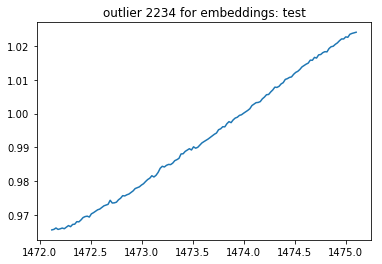

-2.293839355621166


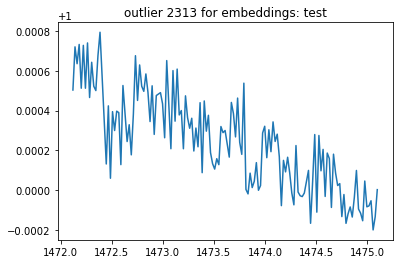

-2.155719972743146


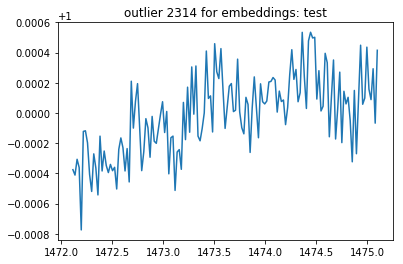

-2.0176005898651264


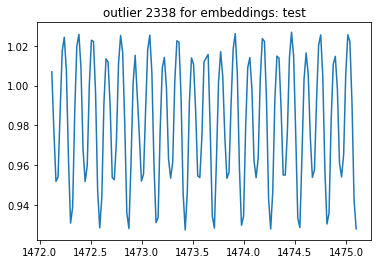

-2.293839355621166


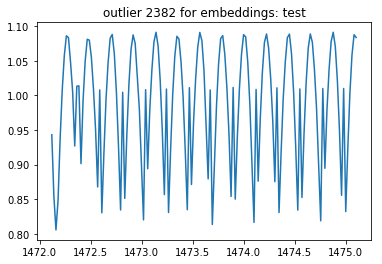

-2.3333020364434574


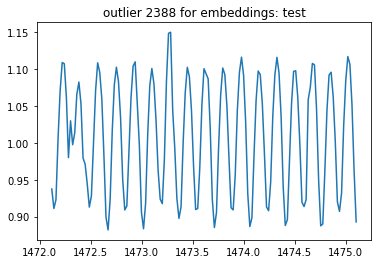

-2.3333020364434574


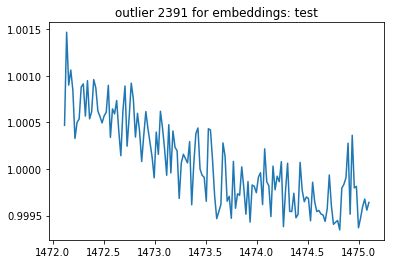

-2.037331930276272


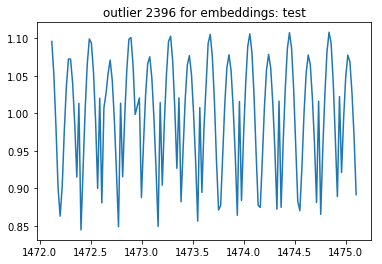

-2.353033376854603


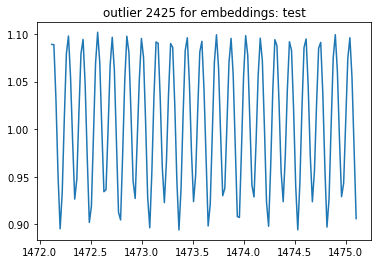

-2.3727647172657487


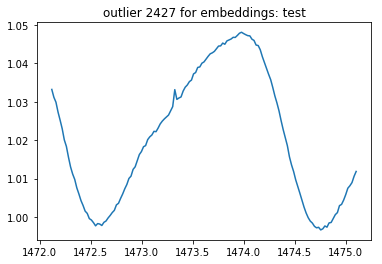

-2.293839355621166


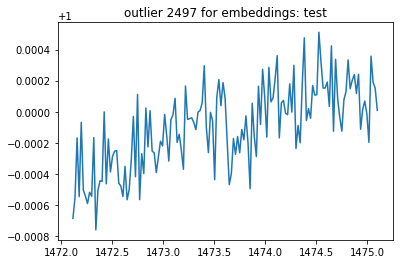

-2.0767946110985633
[3, 12, 15, 63, 108, 128, 129, 135, 136, 142, 169, 219, 230, 310, 326, 332, 350, 360, 397, 415, 421, 423, 562, 582, 615, 639, 655, 683, 696, 743, 756, 823, 853, 863, 872, 883, 902, 931, 1004, 1053, 1058, 1194, 1228, 1242, 1290, 1347, 1363, 1371, 1384, 1386, 1392, 1393, 1457, 1464, 1468, 1470, 1486, 1497, 1619, 1643, 1726, 1757, 1773, 1781, 1799, 1808, 1817, 1831, 1863, 1973, 2000, 2008, 2042, 2048, 2050, 2091, 2092, 2180, 2193, 2222, 2228, 2234, 2313, 2314, 2338, 2382, 2388, 2391, 2396, 2425, 2427, 2497]


In [93]:
# distances = pairwise_distances(embeddings_umap_pca)
outliers, normalized_scores = find_outliers(tsne_embeddings_pca, metric='ball', cutoff=3.4, neg_cutoff=-2.0, r=5)
print (outliers)

In [94]:
for i in np.array(normalized_scores).argsort()[:9]:
    print str(outliers[i]) + ",",

2228, 423, 2092, 1973, 142, 883, 1393, 902, 655,


5


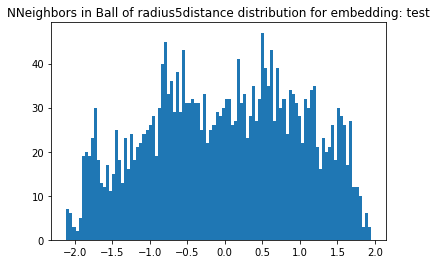

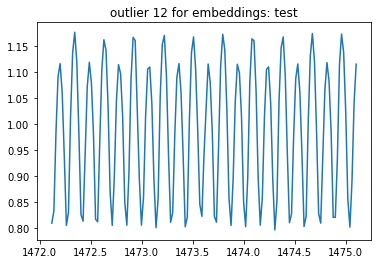

-2.0718563562026495


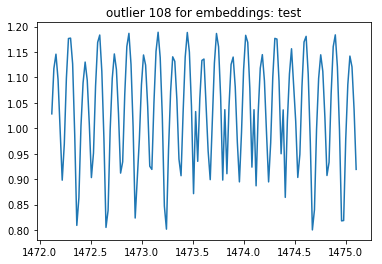

-2.1096362119473118


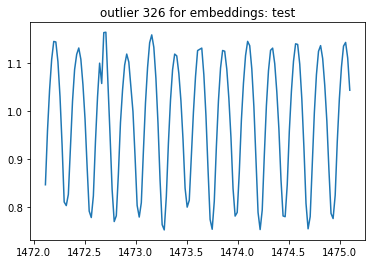

-2.1096362119473118


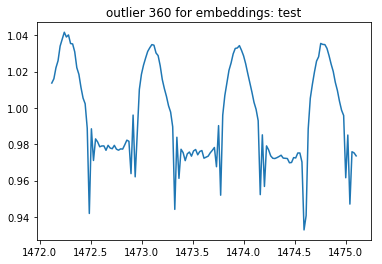

-2.0529664283303184


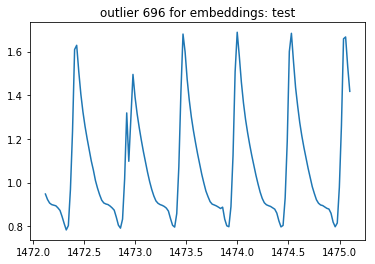

-2.0869682985005142


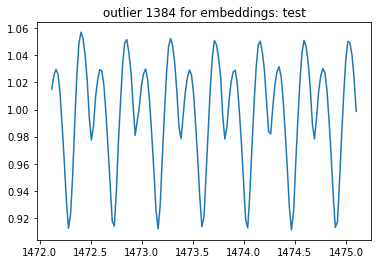

-2.064300385053717


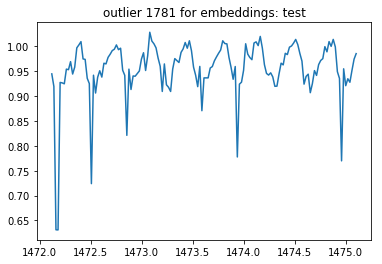

-2.0718563562026495


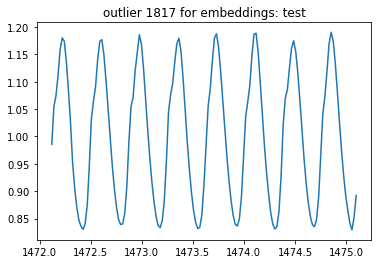

-2.022742543734589


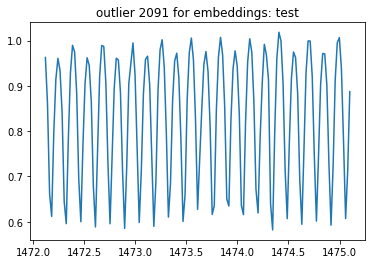

-2.068078370628183


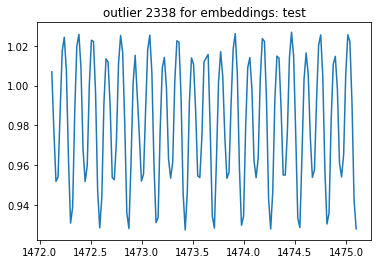

-2.0340765004579873


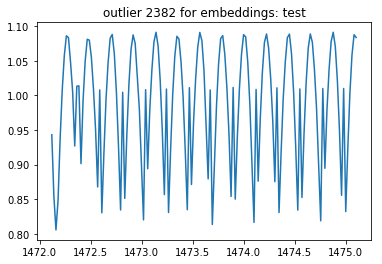

-2.0869682985005142


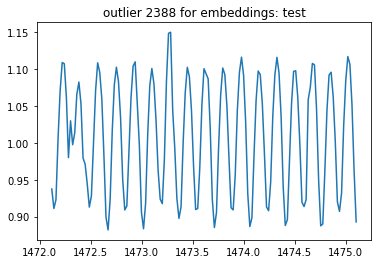

-2.0189645581601225


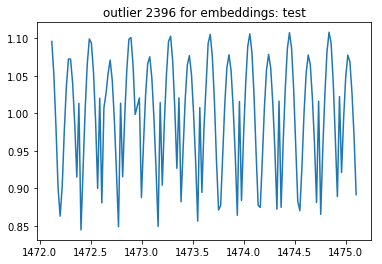

-2.068078370628183


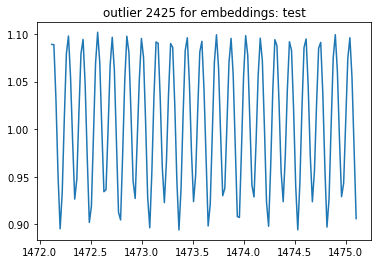

-2.064300385053717


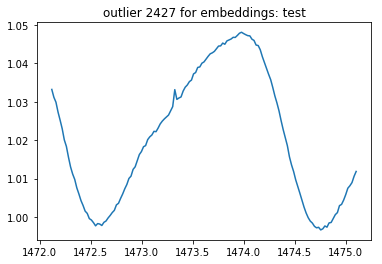

-2.0718563562026495
[12, 108, 326, 360, 696, 1384, 1781, 1817, 2091, 2338, 2382, 2388, 2396, 2425, 2427]


In [127]:
outliers, normalized_scores = find_outliers(embeddings_umap_pca, metric='ball', cutoff=3.4, neg_cutoff=-2.0, r=5)
print (outliers)

In [128]:
for i in np.array(normalized_scores).argsort()[:9]:
    print str(outliers[i]) + ",",

108, 326, 696, 2382, 12, 1781, 2427, 2091, 2396,


In [129]:
def create_outliers_plot(outliers, show_error=False):
#     fig, ax = plt.subplots(nrows=3, ncols=3)
    f, axarr = plt.subplots(3, 3)
#     f.set_size_inches(18.5, 10.5)
    row = 0
    for i, outlier in enumerate(outliers):
        col = i % 3
        if col == 0:
            row += 1
        
        print "ON OUTLIER " + str(outlier)
#         x = kdata[outlier][0]
#         y = kdata[outlier][1]
#         y_err = kdata[outlier][2]
        x = data[4][outlier].T[0]
        y = data[4][outlier].T[1]
        y_err = data[4][outlier].T[2]
        ar_x = row - 1
        ar_y = col
        axarr[ar_x, ar_y].set_title(outlier)
        axarr[ar_x, ar_y].set_xticks([])
        axarr[ar_x, ar_y].set_yticks([])
        if show_error:
            axarr[ar_x, ar_y].errorbar(x, y, yerr=y_err,fmt=".")
        else:
            axarr[ar_x, ar_y].plot(x, y)
            
    # DO MANUAL STUFF HERE

#     axarr[2, 1].set_visible(False)
    axarr[2,2].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("final_images_sparse/UMAP_test_outliers.ps", dpi=100)
    plt.close()
        
        
outliers = [108, 326, 696, 2382, 12, 1781, 2427, 2091, 239]
create_outliers_plot(outliers)

ON OUTLIER 108
ON OUTLIER 326
ON OUTLIER 696
ON OUTLIER 2382
ON OUTLIER 12
ON OUTLIER 1781
ON OUTLIER 2427
ON OUTLIER 2091
ON OUTLIER 239
